# Ejercicios de apliación métodos de reducción de varianza y generación de variables aleatorias

### Recordar el método de aceptación y rechazo y mostrar las posibles simplificaciones

1. Generar $R_1$ teniendo densidad $g(x)$ 
2. Generar $R_2 \rightarrow U \sim U(0,1)$ independiente de $R_1$ del paso 1 .
3. Evaluar la función de probabilidad en $R_1$.
4. Determinar si la siguiente desigualdad se cumple: 
$$R_2\leq \frac{f(R_1)}{t(R_1)}\rightarrow R_2 t(R_1) \le f(R_1)$$
   Si la respuesta es afirmativa se utiliza $X=R_1$, de lo contrario es necesario pasar nuevamente al paso 1, tantas veces como sea necesario.
   
**Con esto en mente creemos una función que simplifique el método**

In [1]:
import numpy as np
from functools import reduce
import time
import matplotlib.pyplot as plt
import scipy.stats as st     # Librería estadística
import pandas as pd
from scipy import optimize

In [35]:
np.random.uniform()

0.14598754574568862

In [36]:
# Función de aceptación y rechazo usando una constante para t(x) y se desea que dicha función regrese
# N variables aleatorias (Exactamente que acepte N valores)
def acep_rechazo_simplificada(
    N:'Cantidad de variables a generar',
    Dom_f:'Dominio de la función f como tupla (a,b)',
    f:'función objetivo a generar',
    max_f:'máximo valor de f'
):
    X = np.zeros(N)
    i = 0
    while i < N:
        R1 = np.random.uniform(*Dom_f)
        R2 = np.random.uniform()
        condicion = R2 * max_f <= f(R1)
        if condicion:
            X[i] = R1
            i += 1
    return X

In [37]:
# Función que grafica subplots para cada señal de distribución Erlang
def histograma_vs_densidad(signal:'variable con muestras aleatorias de la distribución generada',
                           f:'función de distribución de probablidad f(x) de la variable aleatoria'):

    plt.figure(figsize=(8,3))
    count, x, _ = plt.hist(signal,100,density=True)
    y = f(x)
    plt.plot(x, y, linewidth=2,color='k')
    plt.ylabel('Probabilidad')
    plt.xlabel('Muestras')
#     plt.legend()
    plt.show()

In [38]:
def Gen_distr_discreta(p_acum: 'P.Acumulada de la distribución a generar',
                       indices: 'valores reales a generar aleatoriamente',
                       N: 'cantidad de números aleatorios a generar'):
    
    U =np.random.rand(N)
    # Diccionario de valores aleatorios
    rand2reales = {i: idx for i, idx in enumerate(indices)}

    # Series de los valores aletorios
    y = pd.Series([sum([1 for p in p_acum if p < ui]) for ui in U]).map(rand2reales)

    return y

In [44]:
def plot_histogram_discrete(distribucion:'distribución a graficar histograma',
                            label:'label del legend'):
    # len(set(distribucion)) cuenta la cantidad de elementos distintos de la variable 'distribucion'
    plt.figure(figsize=[8,4])
    y, x = np.histogram(distribucion, density = True, bins = len(set(distribucion))) 
    x = x[1:]
    plt.bar(list(set(distribucion)),y,label=label)
    plt.legend()
    plt.show()

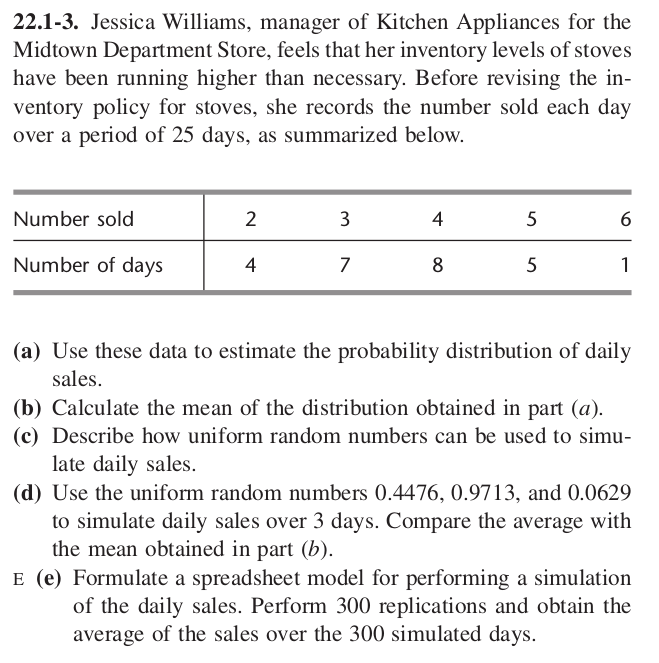

In [42]:
num_vent = [2,3,4,5,6]
num_dias = [4,7,8,5,1]

p = np.array(num_dias) / sum(num_dias)
p_acum = p.cumsum()

data = pd.DataFrame(columns=['num_dias','probabilidad','p_acumulada'], index=num_vent)
data['num_dias'] = num_dias
data['probabilidad'] = p
data['p_acumulada'] = p_acum

data.index.name = 'num_ventas'
data

,num_dias,probabilidad,p_acumulada
num_ventas,,,
2,4,0.16,0.16
3,7,0.28,0.44
4,8,0.32,0.76
5,5,0.20,0.96
6,1,0.04,1.00


# Transformada inversa

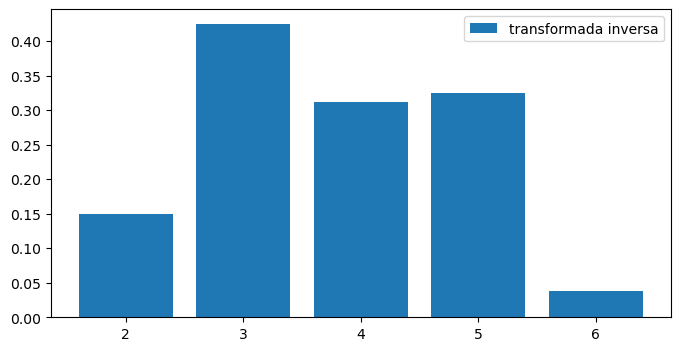

In [56]:
np.random.seed(55)
N = 100

m1 = Gen_distr_discreta(p_acum, num_vent, N)

plot_histogram_discrete(m1,'transformada inversa')

## Estimar media


Fórmula para estimar la media de una distribución discreta
$$
\mathbb {E} [X]=x_{1}p(X=x_{1})+...+x_{n}p(X=x_{n})=\sum _{i=1}^{n}x_{i}p(x_{i})
$$

In [57]:
# Calcular la media teórica según la ecuación anterior
media_teorica = (np.array(num_vent) * p).sum()
media_teorica

3.6800000000000006

 # a) Montecarlo
 

In [58]:
# Usar montecarlo crudo para estimar la media
m_crudo = m1.mean()
m_crudo 

3.74

# b) Muestreo estratificado

- 30% de las muestras entre 0 y 0.2
- 40% de las muestras entre 0.2 y 0.8
- 30% de las muestras entre 0.8 y 1

In [85]:
def Gen_distr_discreta_red_varianza(
    p_acum: 'P.Acumulada de la distribución a generar',
    indices: 'valores reales a generar aleatoriamente',
    U: 'Variables aleatorias'
):
    
#     U =np.random.rand(N)
    # Diccionario de valores aleatorios
    rand2reales = {i: idx for i, idx in enumerate(indices)}

    # Series de los valores aletorios
    y = pd.Series([sum([1 for p in p_acum if p < ui]) for ui in U]).map(rand2reales)

    return y.to_numpy()

In [86]:
# Estimar la media usando el método de muestreo estratificado con distinto tamaño de estratos
r1 = np.random.uniform(0, 0.2, int(0.3 * N))
r2 = np.random.uniform(0.2, 0.8, int(0.4 * N))
r3 = np.random.uniform(0.8, 1, int(0.3 * N))

r = [r1, r2, r3]

w = [0.3/0.2, 0.4/0.6, 0.3/0.2]

m_estra_1 = np.concatenate(
    [Gen_distr_discreta_red_varianza(p_acum, num_vent, r[i])/w[i]  for i in range(len(r))]
).mean()
m_estra_1

3.681666666666666

# c) Estratificado 2
Escribir una función en donde le ingreses el número de estratos y esta te retorne un conjunto de variables aleatorias donde todos los estratos se encuentran igualmente espaciadas

In [89]:
def estra_igualmente_espaciado(a, b, B):
    """
    Escribir la función acá y comentarla
    """
    Ui = np.random.uniform(a, b, N)
    i = np.arange(0, B)
    Ui_estra = (Ui + i) / B
    return Ui_estra

In [90]:
u_estra = estra_igualmente_espaciado(0, 1, N)

m3 = Gen_distr_discreta_red_varianza(p_acum, num_vent, u_estra)

print('Estratificado 2 =',np.mean(m3))


Estratificado 2 = 3.68


# d) complementario


In [91]:
u1 = np.random.rand(N)
u1_c = 1 - u1
u_complementario = np.concatenate([u1, u1_c])

m4 = Gen_distr_discreta_red_varianza(p_acum, num_vent, u_complementario)

print('Complementario =',np.mean(m4))

Complementario = 3.65


# Ejercicio 2
Distribución geométrica (Método de aceptación y rechazo distribuciones discretas)
$$ f(x) = p(1-p)^{x-1}, \quad x\in 1,2,3,4,5,\cdots$$

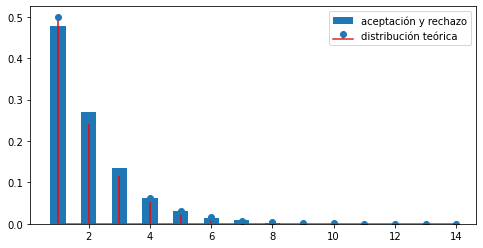

In [60]:
# Generar variables aleatorias de f(x) usando aceptaciṕn y rechazo
N = 1000
p = 0.5
f_x = lambda x: p*(1-p)**(x-1)
max_f = 

# Ejercicio 
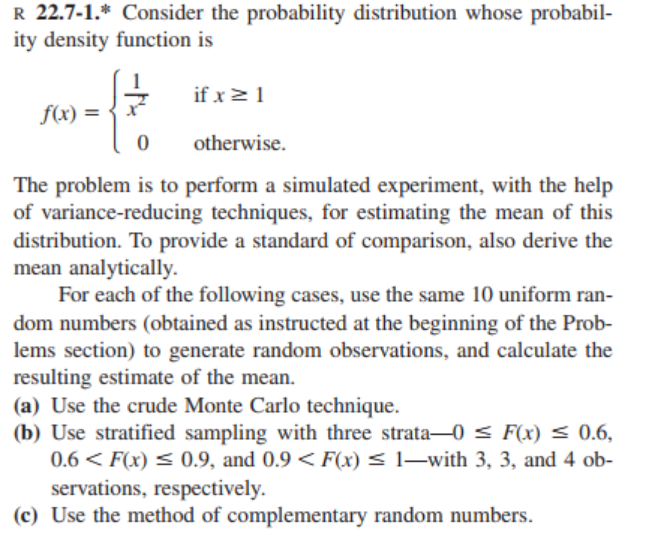

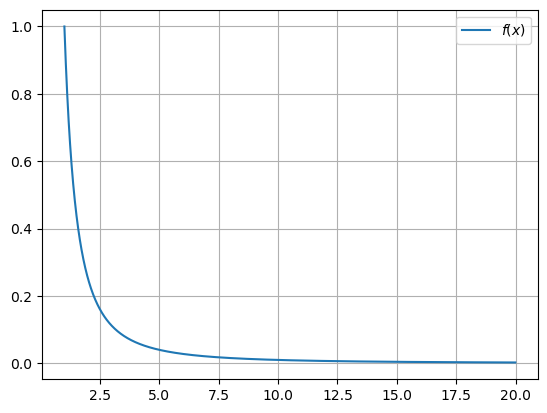

In [119]:
f_x = lambda x: 1/x**2 if x>=1 else 0
f_x = np.vectorize(f_x, otypes=[float])

x = np.arange(1, 20, 0.01)

plt.plot(x, f_x(x), label='$f(x)$')
plt.legend()
plt.grid()

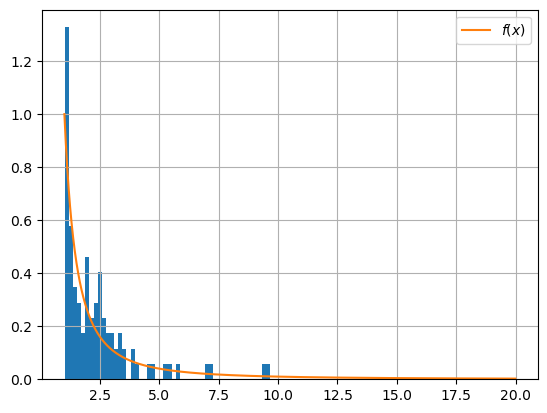

In [151]:
N = 100
Dom_f = (1, 10)

x_random1 = acep_rechazo_simplificada(N, Dom_f, f_x, 1)
# condicion.sum()

plt.hist(x_random1, bins=50, density=True)

plt.plot(x, f_x(x), label='$f(x)$')
plt.legend()
plt.grid()

plt.show()

 # a) Montecarlo
 

In [153]:
x_random1.mean()


2.3571703818011693

# b) Muestreo estratificado


In [173]:
Dom_f = (1, 10)
max_f = 1
N = 1000

R1_estra = estra_igualmente_espaciado(*Dom_f, N)
R2_estra = estra_igualmente_espaciado(0, 1, N)
# R1 = np.random.uniform(*Dom_f, N)
# R2 = np.random.uniform(0, 1, N)
condicion = R2_estra * max_f <= f_x(R1_estra)
x_random2 = R1_estra[condicion]
x_random2.mean()

1.0000216530902974

In [46]:
np.random.seed(100)


In [49]:
muestras2
np.concatenate(estra1).mean()

3.1414011761124687

# c) Estratificado 2

In [55]:
rand = estra_igualmente_espaciado(10)

np.mean(muestras3)

3.6043778002853335

# d) complementario


In [179]:
R1_estra = estra_igualmente_espaciado(*Dom_f, N)
R1_comple = Dom_f[1] - R1_estra + Dom_f[0]
R1_concat = np.concatenate([R1_estra, R1_comple])

R2_estra = estra_igualmente_espaciado(0, 1, N)
R2_comple = 1 - R2_estra
R2_concat = np.concatenate([R1_estra, R2_comple])

# R1 = np.random.uniform(*Dom_f, N)
# R2 = np.random.uniform(0, 1, N)
condicion = R2_concat * max_f <= f_x(R1_concat)
x_random3 = R1_concat[condicion]
x_random3.mean()

10.000900751201787